## **i. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **ii. Import the libraries**
---

In [2]:
import cv2
import sys
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

print("Versions of key libraries")
print("---")
print("cv2:       ", cv2.__version__)
print("numpy:     ", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("pandas.   :", pd.__version__)


Versions of key libraries
---
cv2:        4.1.2
numpy:      1.19.5
matplotlib: 3.2.2
pandas.   : 1.1.5


## **iii. Append /iss/vse/data/ in your python path**
---

In [3]:
sys.path.append('/content/gdrive/My Drive/Mtech/VSE/data/')
print("All the system paths:")
sys.path

All the system paths:


['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Mtech/VSE/data/']

## **iv. Change working directory to /iss/vse/data/**
---

In [4]:
os.chdir('/content/gdrive/My Drive/Mtech/VSE/data/')
print("Current working directory:")
os.getcwd()

Current working directory:


'/content/gdrive/My Drive/Mtech/VSE/data'

## **v. Define `cv2plt` for image display**
---

In [5]:
def cv2plt(img):
    plt.figure(figsize=(8,8))        # To change the size of figure
    plt.axis('off')
    if np.size(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img,cmap='gray',vmin=0,vmax=255)  
    plt.show()

print(cv2plt)

<function cv2plt at 0x7f91ce0eb840>


## **vi. Setup YOLO v3**
---

In [6]:
lbl_file        = 'yolov3.txt'
classes         = open(lbl_file).read().strip().split("\n")

                                                # Read in the deep learning net
yoloconfig      = 'yolov3.cfg'
yoloweights     = 'yolov3.weights'
net             = cv2.dnn.readNet(yoloweights,yoloconfig)

pd.DataFrame(classes)                           # Display the first five and the last five classes

,0
0,person
1,bicycle
2,car
3,motorcycle
4,airplane
...,...
75,vase
76,scissors
77,teddy bear
78,hair drier


## **Question a**
---
Create a function that receives an image and returns bounding boxes and their corresponding class labels. The function should have the below signature:<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;`def yoloV3Detect(img,scFactor=1/255,nrMean=(0,0,0),RBSwap=True,scoreThres=0.5,nmsThres=0.4)`<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`...`

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`return [fboxes,fclasses]`<br><br>


Try to perform object detections on image 'sr1.jpg', 'sr2.jpg' and etc.

In [66]:
# Type your code below

def yoloV3Detect(img,scFactor=1/255,nrMean=(0,0,0),RBSwap=True,scoreThres=0.5,nmsThres=0.4):
  (imgHeight, imgWidth, _) = img.shape
  blob = cv2.dnn.blobFromImage(image=img,
    scalefactor=scFactor,
    size=(416, 416),
    mean=nrMean,
    swapRB=RBSwap,
    crop=False)
  net.setInput(blob)
  layers = net.getLayerNames()
  outLayers = [layers[i[0] - 1] for i in net.getUnconnectedOutLayers()]
  preds = net.forward(outLayers)
  all_boxes = []
  all_classes = []
  all_scores = []
  for scale in preds:
    for pred in scale:
      scores = pred[5:]
      max_score_index = np.argmax(scores)
      confidence = scores[max_score_index]
      if (confidence > scoreThres):
        xc = int(pred[0]*imgWidth)
        yc = int(pred[1]*imgHeight)
        w = int(pred[2]*imgWidth)
        h = int(pred[3]*imgHeight)
        x = int(xc - w/2)
        y = int(yc - h/2)
        all_boxes.append([x, y, w, h])
        all_classes.append(max_score_index)
        all_scores.append(float(confidence))
  selected_indexes = cv2.dnn.NMSBoxes(bboxes=all_boxes, scores=all_scores, score_threshold=scoreThres, nms_threshold=nmsThres)
  fboxes = []
  fclasses = []
  for index in selected_indexes[:,0]:
    fboxes.append(all_boxes[index])
    fclasses.append(all_classes[index])
  
  return [fboxes, fclasses]

yoloV3Detect(cv2.imread('sr6.jpg'))

[[[320, 106, 216, 242],
  [235, 361, 168, 209],
  [218, 48, 17, 15],
  [183, 39, 12, 13],
  [164, 42, 12, 11],
  [140, 46, 12, 10],
  [530, 121, 18, 53],
  [280, 46, 26, 27],
  [230, 125, 41, 47],
  [185, 35, 9, 9],
  [236, 42, 27, 37],
  [206, 34, 11, 10]],
 [5, 2, 2, 2, 2, 2, 0, 2, 2, 2, 7, 2]]

## **Question b**
---
Create a function that receives an image, `fboxes`, `fclasses` and `classes`, and produce the output in the below fashion.<br><br>

The name of the function should be `pltDetect`

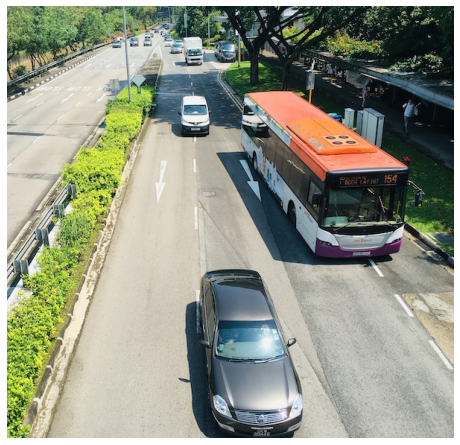

In [65]:
# Run the below to display the required type of output. The output below comes from image "sr6.jpg"

cv2plt(cv2.imread('sr6.jpg'))

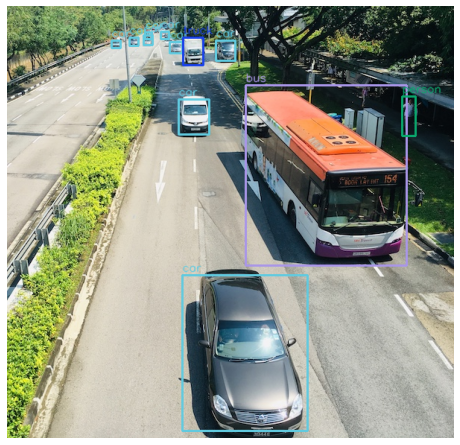

In [64]:
def drawResult (img, fboxes, fclasses, classes):
  colorset = np.random.uniform(0, 255, size=(len(classes),3))
  output = img[::]
  for i in range(0, len(fboxes)):
    [x,y,w,h] = fboxes[i]
    classIndex = fclasses[i]
    className = classes[classIndex]
    color = colorset[classIndex]
    output = cv2.rectangle(
      output, 
      (x, y), 
      (x + w, y + h), 
      color, 
      2
    )
    cv2.putText(output,
      className,
      (x,y-5),
      cv2.FONT_HERSHEY_SIMPLEX,
      0.5,
      color,
      1,
      cv2.LINE_AA)
  cv2plt(output)

img = cv2.imread('sr6.jpg')
[fboxes, fclasses] = yoloV3Detect(img)
drawResult(img, fboxes, fclasses, classes)
